## Importing the libraries and seting the paths

In [14]:
from utils import open_nea_table, download_nea_table
import pandas as pd
import numpy as np
import os
import sys
from datetime import date
import math

from utils import open_nea_table, download_nea_table
from mr_utils import creating_MR_ML_table, creating_R_ML_table, MR_plot
from mr_ml_utils import RF_training_with_display, RF_training

If needed to update the NEA table then first run  "download_nea_table"

In [15]:
#download_nea_table()

In [16]:
#If needed to update the NEA table then first run  "download_nea_table"
#download_nea_table()
nea_full_table = open_nea_table()

# Creating the final table with R, M, and Teq.
MR_ML_table = creating_MR_ML_table(nea_full_table)

/home/vadibekyan/my_github/ExoCodes/utils.py:52: DtypeWarning: Columns (65) have mixed types. Specify dtype option on import or set low_memory=False.
  nea_full_table = pd.read_csv(table_directory)
/home/vadibekyan/my_github/ExoCodes/mr_utils.py:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nea_with_M_and_R_cleaned['Teq'] = 0


# Starting the Machine Learning part

Since the accuracy of Mass estimation is not critical, I'll make things simple (but still keeping the state-of-the-art): 

Use Random Forest regressor and tune HyperParameters with "optuna" (sometimes better than grid_search see e.g. [this](https://medium.com/mlearning-ai/hyper-parameter-tuning-through-grid-search-and-optuna-2bd89a2ece06)

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Displaying the data

/home/vadibekyan/my_github/ExoCodes/mr_utils.py:314: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nea_with_R_cleaned['Teq'] = 0


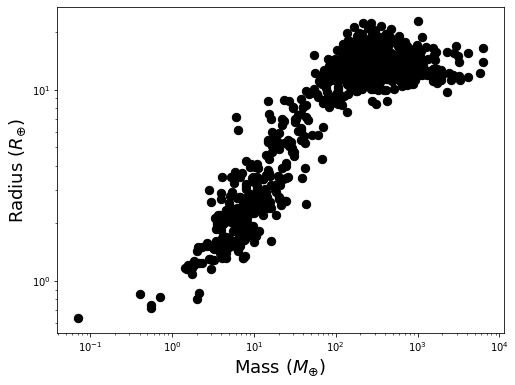

In [18]:
fig = plt.figure(1, figsize = (8,6))
ax = plt.subplot(1,1,1)
MR_plot(ax, MR_ML_table.pl_bmasse, MR_ML_table.pl_rade, color = 'black', label = 'MR data')
R_ML_table = creating_R_ML_table(nea_full_table)


In [19]:
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor


Selecting our target variable ( y = planetary mass) and the input features (X =[Teff, metallicity, radius, orbital semi-major axis, Teq])

In [20]:
y = MR_ML_table['pl_bmasse']
X = MR_ML_table.drop(columns = ['pl_bmasse'])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

# Testing hyperparameters for overfitting/underfitting

In [22]:
def modified_learning_curve(X_train, y_train, X_test, y_test, model, N, CV=5):
    """
    Calculate and plot the modified learning curve for a given model.

    Parameters:
        X_train (array-like): The input features of the training dataset.
        y_train (array-like): The target variable of the training dataset.
        X_test (array-like): The input features of the test dataset.
        y_test (array-like): The target variable of the test dataset.
        model: The machine learning model used for prediction.
        N (int): The number of data points to be used in the learning curve.
        CV (int): The number of cross-validation folds (default: 5).
    Returns:
        DataFrame: The learning curve results.

    """

    # Generate an array of training sizes
    train_sizes = np.linspace(0.05, 0.99, N)

    # Create an empty DataFrame to store the learning curve results
    results = pd.DataFrame(columns=['train_size', 'mae_train_mean', 'mae_train_std', 'mae_test_mean', 'mae_test_std'],
                           index=range(0, N))

    # Iterate over the training sizes
    for i, train_size in enumerate(train_sizes):
        mae_train = []
        mae_test = []

        # Repeat the cross-validation process for each training size
        for j in range(CV):
            # Split the training set into a subset based on the current training size
            X_train_tmp, _, y_train_tmp, _ = train_test_split(X_train, y_train, test_size=(1 - train_size))

            # Fit the model on the subset of training data
            model.fit(X_train_tmp, y_train_tmp)

            # Make predictions on the test set
            y_pred_test = model.predict(X_test)
            y_pred_train_tmp = model.predict(X_train_tmp)

            # Evaluate the model using mean absolute error
            mae_train.append(mean_absolute_error(y_train_tmp, y_pred_train_tmp))
            mae_test.append(mean_absolute_error(y_test, y_pred_test))

        # Store the learning curve results in the DataFrame
        results['train_size'][i] = len(X_train_tmp)
        results['mae_train_mean'][i] = np.mean(mae_train)
        results['mae_train_std'][i] = np.std(mae_train)
        results['mae_test_mean'][i] = np.mean(mae_test)
        results['mae_test_std'][i] = np.std(mae_test)


    # Convert object columns to numeric type in the DataFrame
    for column in results.columns:
        if results[column].dtype == 'object':
            results[column] = pd.to_numeric(results[column], errors='coerce')


    return results

In [23]:
def LC_plot(param_name, start, end, num_elements, param_scale, X_train, y_train, X_test, y_test, scale):

    int_params = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features']

    if param_scale == 'linear':
        if param_name in int_params:
            param_values = np.linspace(start, end, num_elements, dtype = 'int')
        else:
            param_values = np.linspace(start, end, num_elements)
    elif param_scale == 'log':
        param_values = np.logspace(start, end, num_elements)

    # Calculate the number of subplots needed based on the length of the n_estimators_sequence
    num_subplots = len(param_values)

    # Calculate the number of rows and columns based on the number of subplots
    num_rows = int(num_subplots ** 0.5)  # Square root as the number of rows
    num_cols = (num_subplots + num_rows - 1) // num_rows  # Round up the number of columns


    # Create the subplot grid dynamically
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(num_cols*4, num_rows*3))

    # Flatten the axes array if needed (in case we have fewer subplots than rows*cols)
    ax = ax.flatten()

    for i, param_value in enumerate(param_values):
        params = {param_name: param_value}


        model = RandomForestRegressor(random_state=0, **params)
        results = modified_learning_curve(X_train, y_train, X_test, y_test, model, N= 5, CV=3)

        ax[i].set_xlabel("Training Examples")
        ax[i].set_ylabel("Score")

        ax[i].plot(results['train_size'], results['mae_train_mean'], 'o-', color="r", label="Training Score")
        ax[i].fill_between(results['train_size'], results['mae_train_mean'] + results['mae_train_std'],
                        results['mae_train_mean'] - results['mae_train_std'],
                        alpha=0.15, color='r')

        ax[i].plot(results['train_size'], results['mae_test_mean'], 'o-', color="g", label="Cross-Validation Score")
        ax[i].fill_between(results['train_size'], results['mae_test_mean'] + results['mae_test_std'],
                        results['mae_test_mean'] - results['mae_test_std'],
                        alpha=0.15, color='g')

        ax[i].legend(loc="best")
        ax[i].set_title(f'{param_name} = {param_value}')

        #if scale == 'log':
        #    ax[i].set_ylim(0.05,0.4)
        #elif scale == 'linear':
        #    ax[i].set_ylim(0,400)
        plt.tight_layout()

In [24]:
def LC_plot_old(param_name, start, end, step, X_train, y_train, X_test, y_test, scale):
    param_values = np.arange(start,end,step)

    # Calculate the number of subplots needed based on the length of the n_estimators_sequence
    num_subplots = len(param_values)

    # Calculate the number of rows and columns for the subplot grid
    n_cols = 5
    n_rows = (num_subplots - 1) // n_cols + 1

    # Create the subplot grid dynamically
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, 12))

    for i, param_value in enumerate(param_values):

        params = {param_name: param_value}

        r = i // n_cols
        c = i % n_cols

        model = RandomForestRegressor(random_state=0, **params)
        results = modified_learning_curve(X_train, y_train, X_test, y_test, model, N= 5, CV=3)

        ax[r,c].set_xlabel("Training Examples")
        ax[r,c].set_ylabel("Score")

        ax[r,c].plot(results['train_size'], results['mae_train_mean'], 'o-', color="r", label="Training Score")
        ax[r,c].fill_between(results['train_size'], results['mae_train_mean'] + results['mae_train_std'],
                        results['mae_train_mean'] - results['mae_train_std'],
                        alpha=0.15, color='r')

        ax[r,c].plot(results['train_size'], results['mae_test_mean'], 'o-', color="g", label="Cross-Validation Score")
        ax[r,c].fill_between(results['train_size'], results['mae_test_mean'] + results['mae_test_std'],
                        results['mae_test_mean'] - results['mae_test_std'],
                        alpha=0.15, color='g')

        ax[r,c].legend(loc="best")
        ax[r,c].set_title(f'{param_name} = {param_value}')

        if scale == 'log':
            ax[r,c].set_ylim(0.05,0.4)
        elif scale == 'linear':
            ax[r,c].set_ylim(0,400)
        plt.tight_layout()

### n_estimators

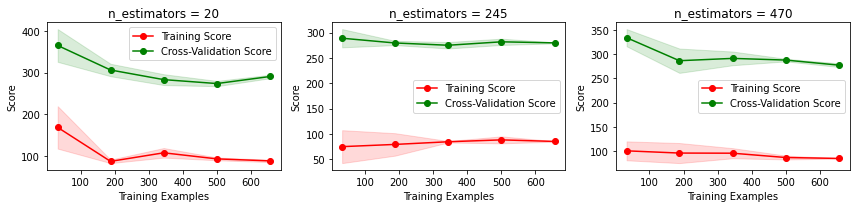

In [25]:
LC_plot('n_estimators', 30, 200, 3, 'linear', X_train, y_train, X_test, y_test, scale = 'linear')

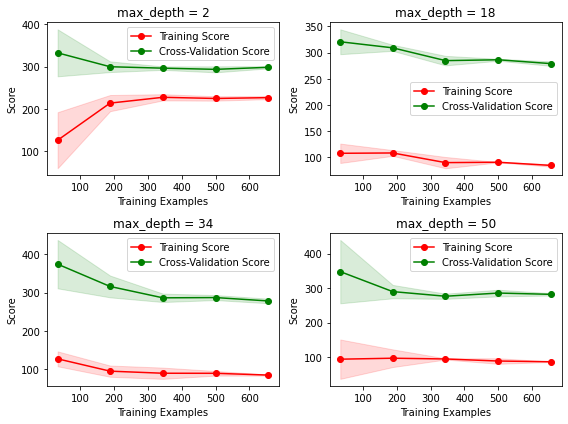

In [27]:
LC_plot('max_depth', 2, 50, 4, 'linear', X_train, y_train, X_test, y_test, scale = 'linear')

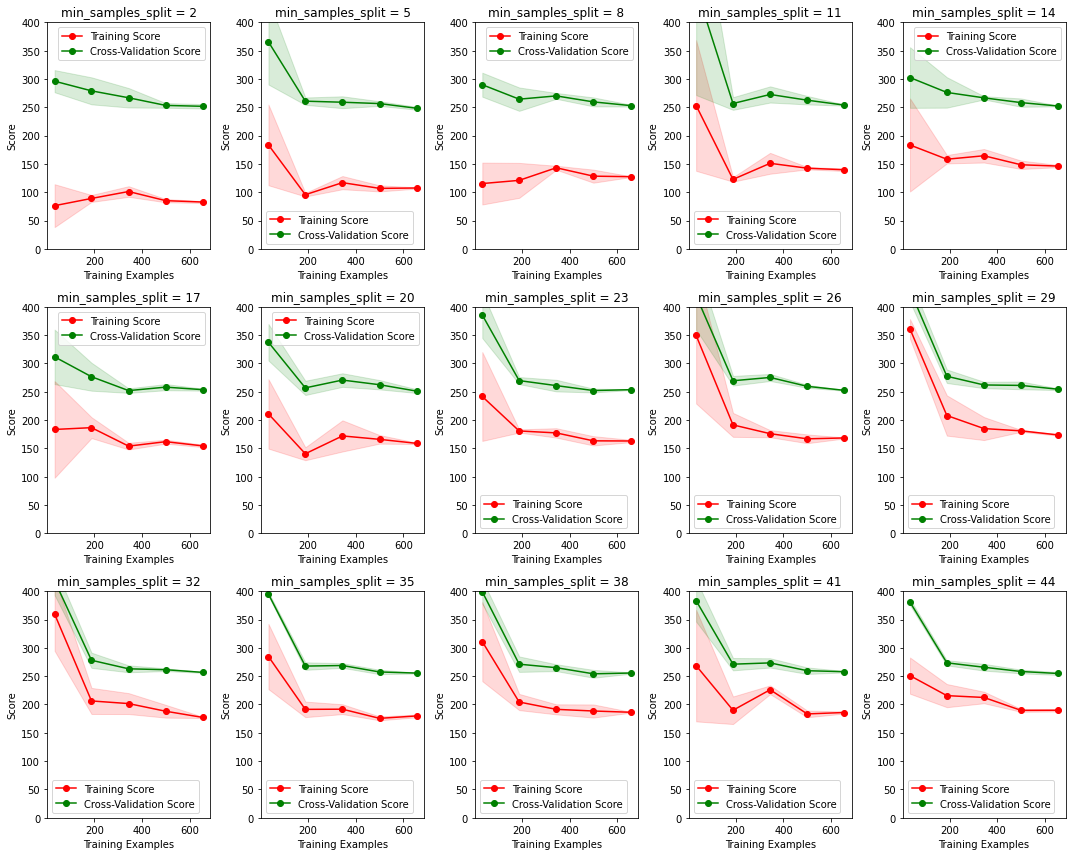

In [ ]:
LC_plot('min_samples_split', 2, 47, 3, X_train, y_train, X_test, y_test, scale = 'linear')

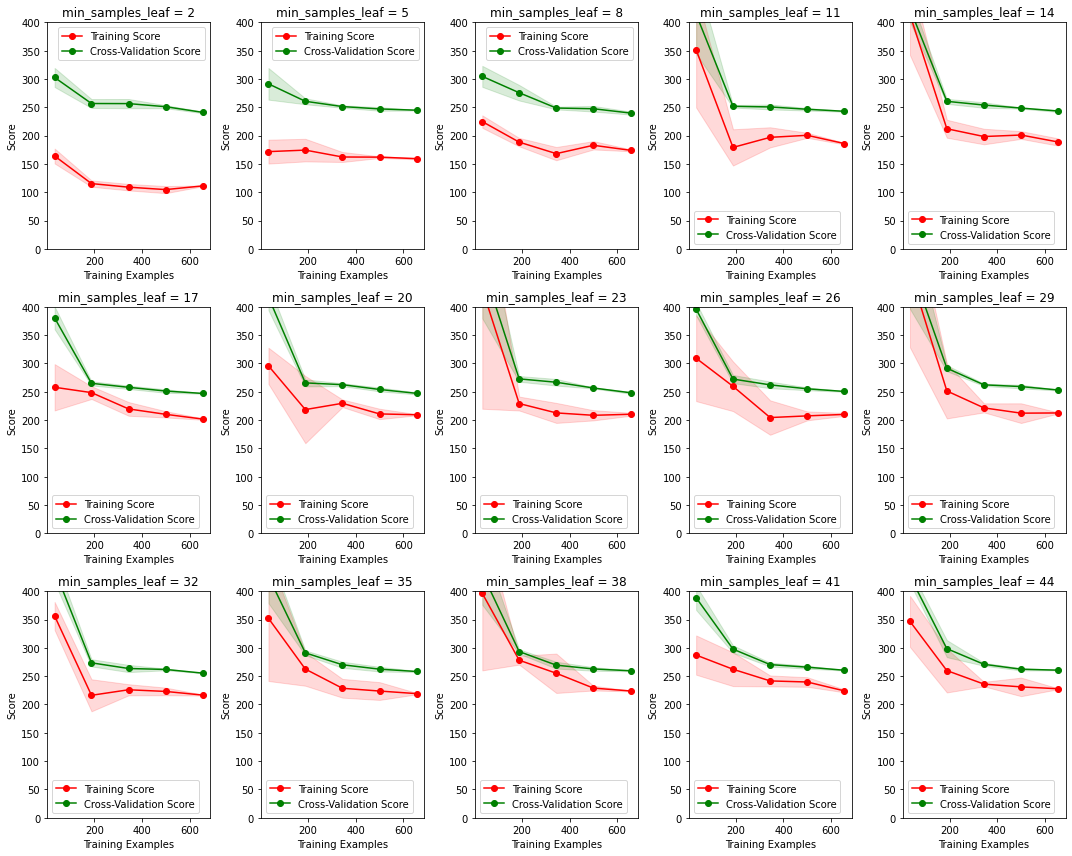

In [ ]:
LC_plot('min_samples_leaf', 2, 47, 3, X_train, y_train, X_test, y_test, scale = 'linear')

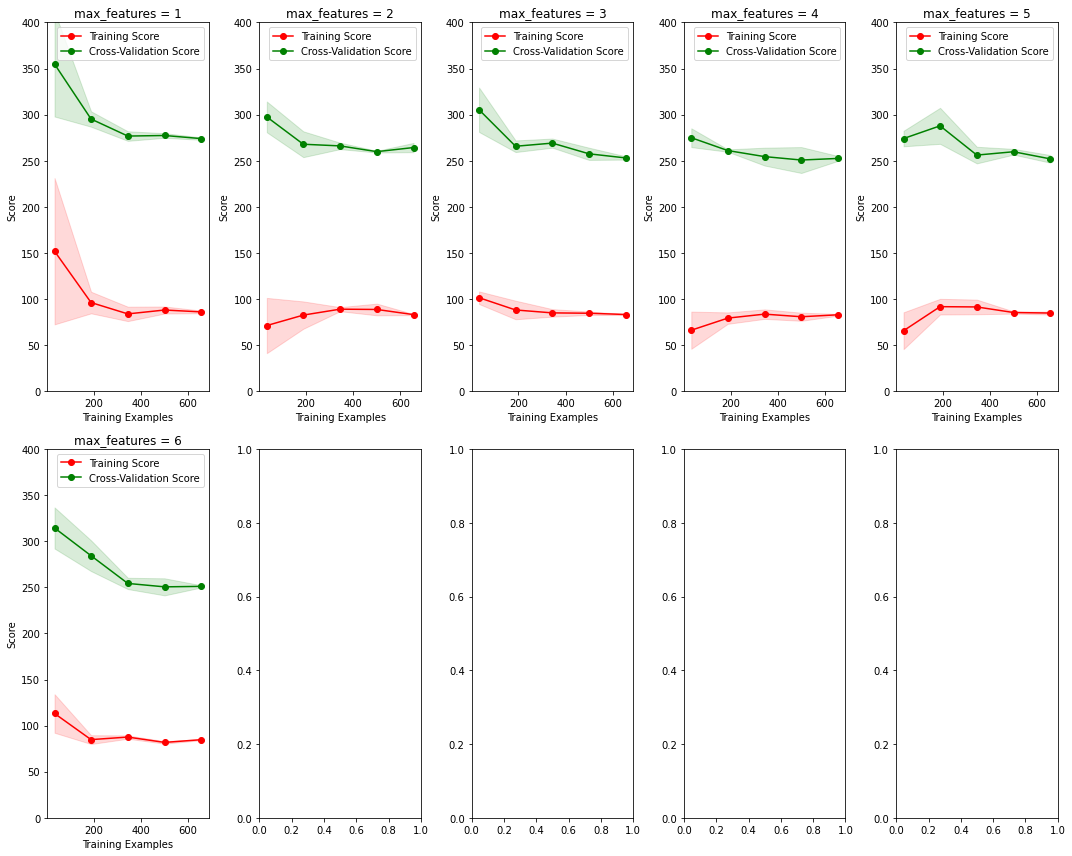

In [ ]:
#LC_plot('max_features', 1, 7, 1, X_train, y_train, X_test, y_test, scale = 'linear')

In [ ]:
def LC_and_predict_plot(param_name, param_values, X_train, y_train, X_test, y_test, scale):

    # Calculate the number of rows and columns for the subplot grid
    n_cols = 3
    n_rows = len(param_values)

    # Create the subplot grid dynamically
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, 15))

    for i, param_value in enumerate(param_values):

        params = {param_name: param_value}

        r = i
        c = 0

        model = RandomForestRegressor(random_state=0, **params)
        results = modified_learning_curve(X_train, y_train, X_test, y_test, model, N= 5, CV=3)

        ax[r,c].set_xlabel("Training Examples")
        ax[r,c].set_ylabel("Score")

        ax[r,c].plot(results['train_size'], results['mae_train_mean'], 'o-', color="r", label="Training Score")
        ax[r,c].fill_between(results['train_size'], results['mae_train_mean'] + results['mae_train_std'],
                        results['mae_train_mean'] - results['mae_train_std'],
                        alpha=0.15, color='r')

        ax[r,c].plot(results['train_size'], results['mae_test_mean'], 'o-', color="g", label="Cross-Validation Score")
        ax[r,c].fill_between(results['train_size'], results['mae_test_mean'] + results['mae_test_std'],
                        results['mae_test_mean'] - results['mae_test_std'],
                        alpha=0.15, color='g')

        ax[r,c].legend(loc="best")
        ax[r,c].set_title(f'{param_name} = {param_value}')
        if scale == 'linear':
            ax[r,c].set_ylim(0,400)
        elif scale == 'log':
            ax[r,c].set_ylim(0.05,0.4)


        model.fit(X_train, y_train)
        
        if scale == 'linear':
            y_predicted = model.predict(X_test)
            ax[r,c+1].scatter(y_test, X_test['pl_rade'], color = 'grey',  label = 'observed')
        elif scale == 'log':
            y_predicted = np.power(10,model.predict(X_test))
            y_test_log = np.power(10, y_test)
            ax[r,c+1].scatter(y_test_log, X_test['pl_rade'], color = 'grey',  label = 'observed')
        ax[r,c+1].scatter(y_predicted, X_test['pl_rade'], color = 'black',  label = 'predicted')
        ax[r,c+1].legend(loc = 'best')
        ax[r,c+1].set_xscale('log')
        ax[r,c+1].set_yscale('log')
        ax[r,c+1].set_xlabel('Mass ($M_{\mathrm{\oplus}}$)')
        ax[r,c+1].set_ylabel('Radius ($R_{\mathrm{\oplus}}$')

        if scale == 'linear':
            M_pred = model.predict(R_ML_table)
        elif scale == 'log':
            M_pred = np.power(10,model.predict(R_ML_table))
        ax[r,c+2].scatter(MR_ML_table['pl_bmasse'], MR_ML_table['pl_rade'], color = 'grey',  label = 'observed')
        ax[r,c+2].scatter( M_pred, R_ML_table['pl_rade'], color = 'black',  label = 'predicted')
        ax[r,c+2].legend(loc = 'best')
        ax[r,c+2].set_xscale('log')
        ax[r,c+2].set_yscale('log')
        ax[r,c+2].set_xlabel('Mass ($M_{\mathrm{\oplus}}$)')
        ax[r,c+2].set_ylabel('Radius ($R_{\mathrm{\oplus}}$)')    
        plt.tight_layout()

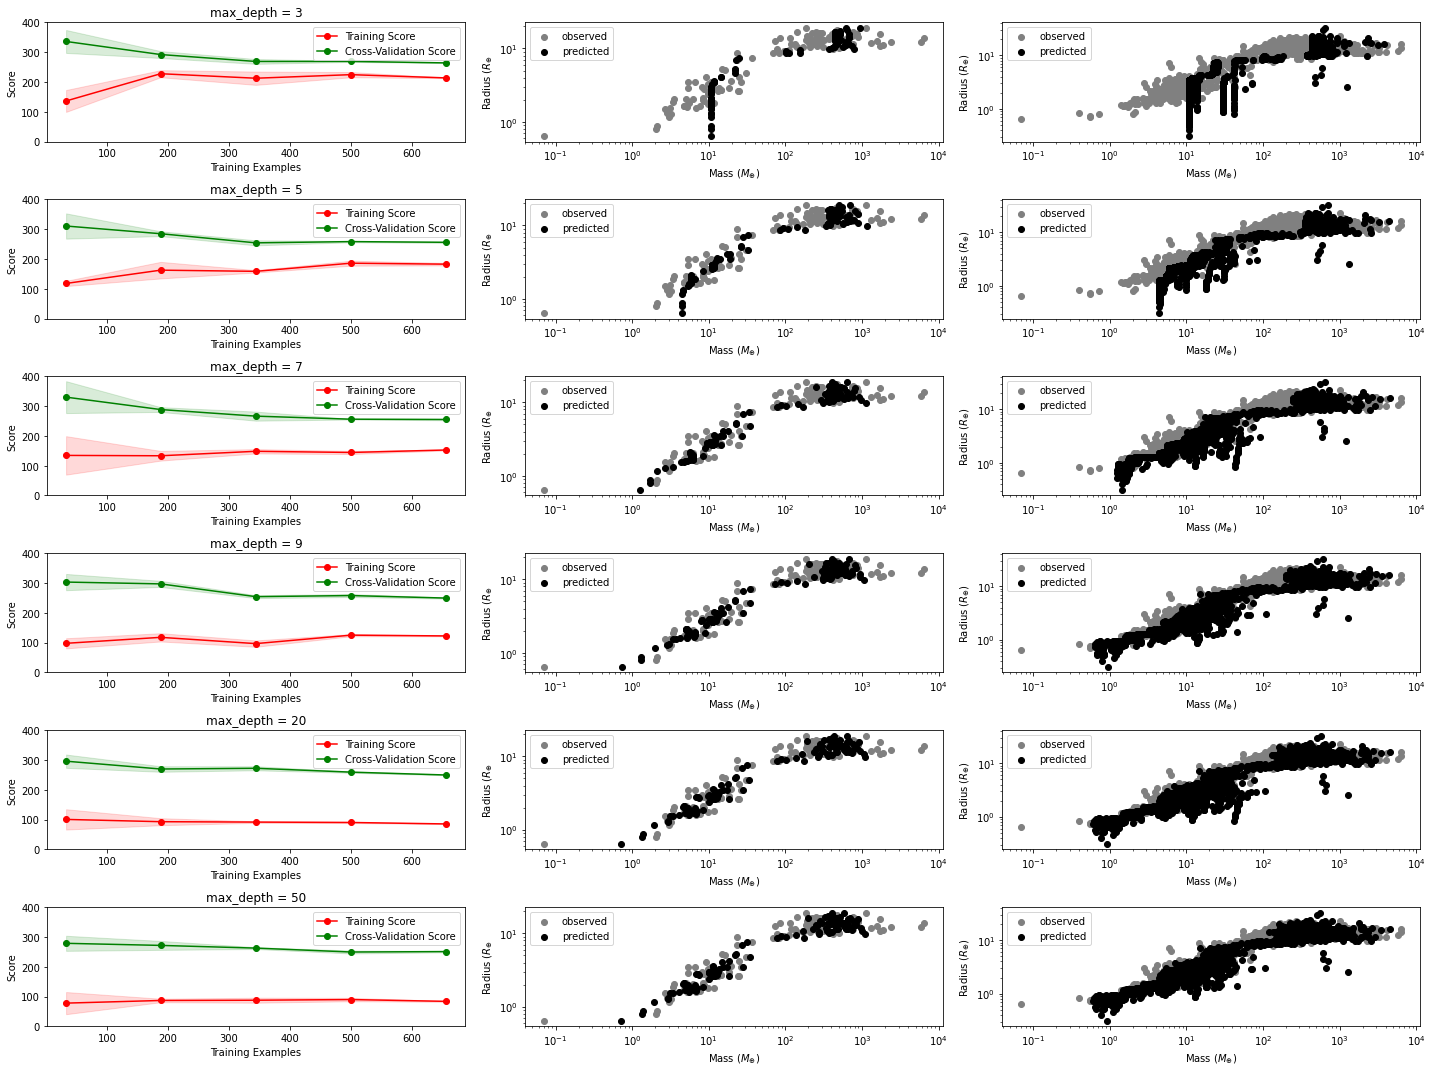

In [ ]:
LC_and_predict_plot('max_depth', [3,5,7,9,20,50], X_train, y_train, X_test, y_test, scale = 'linear')

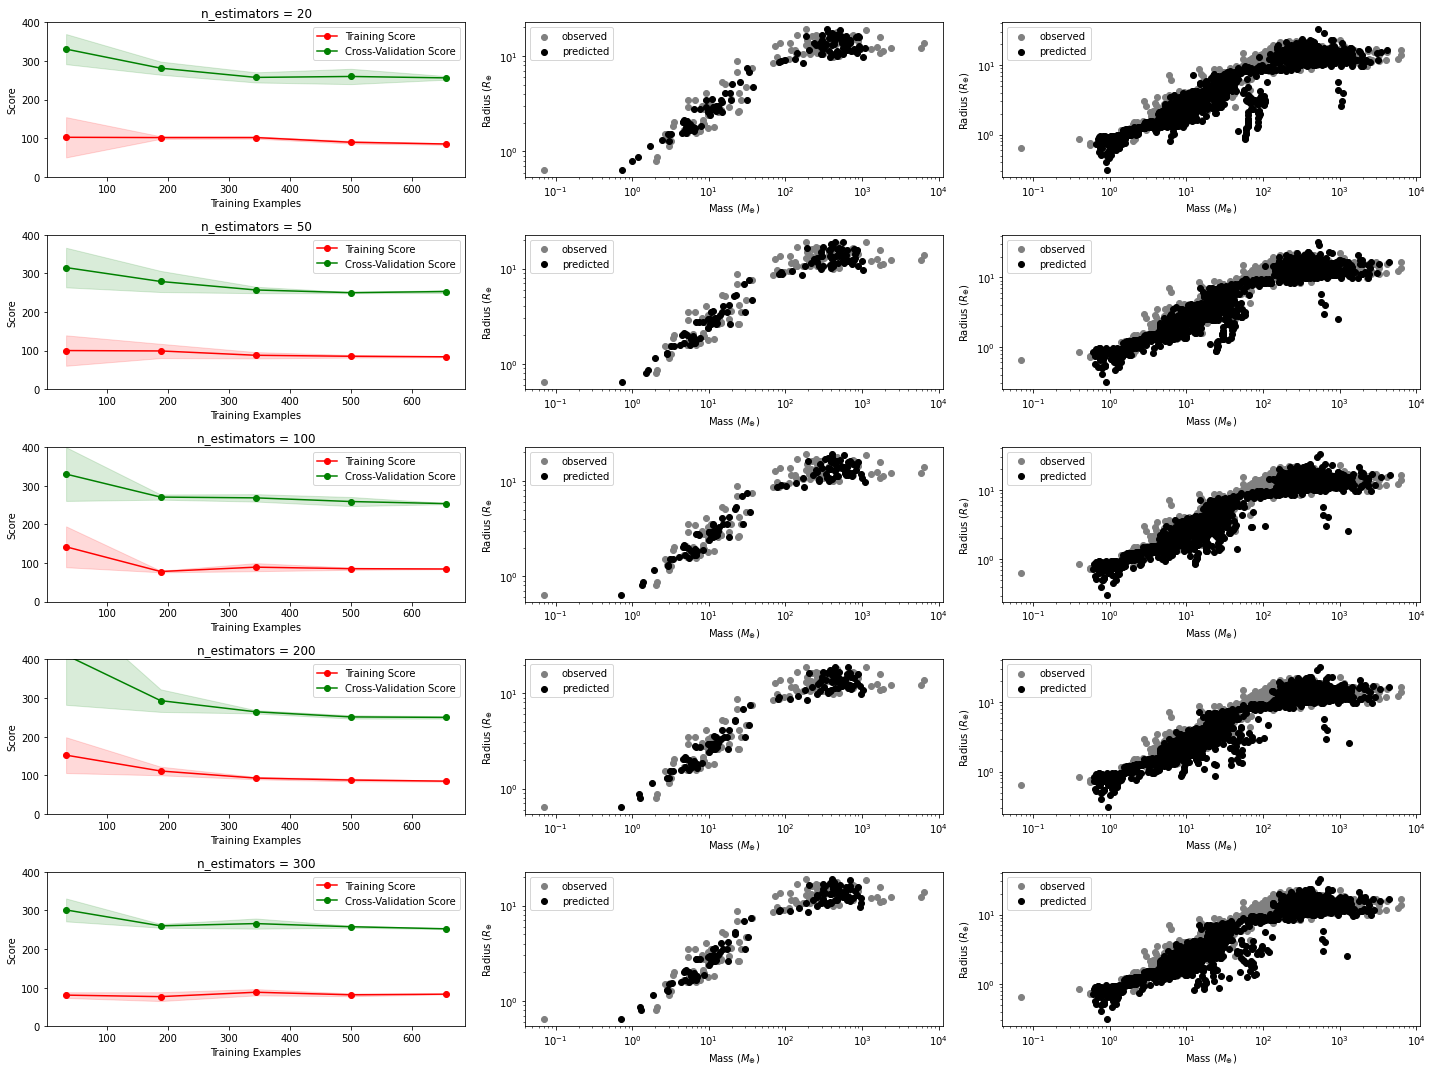

In [ ]:
LC_and_predict_plot('n_estimators', [20,50,100,200,300], X_train, y_train, X_test, y_test, scale = 'linear')

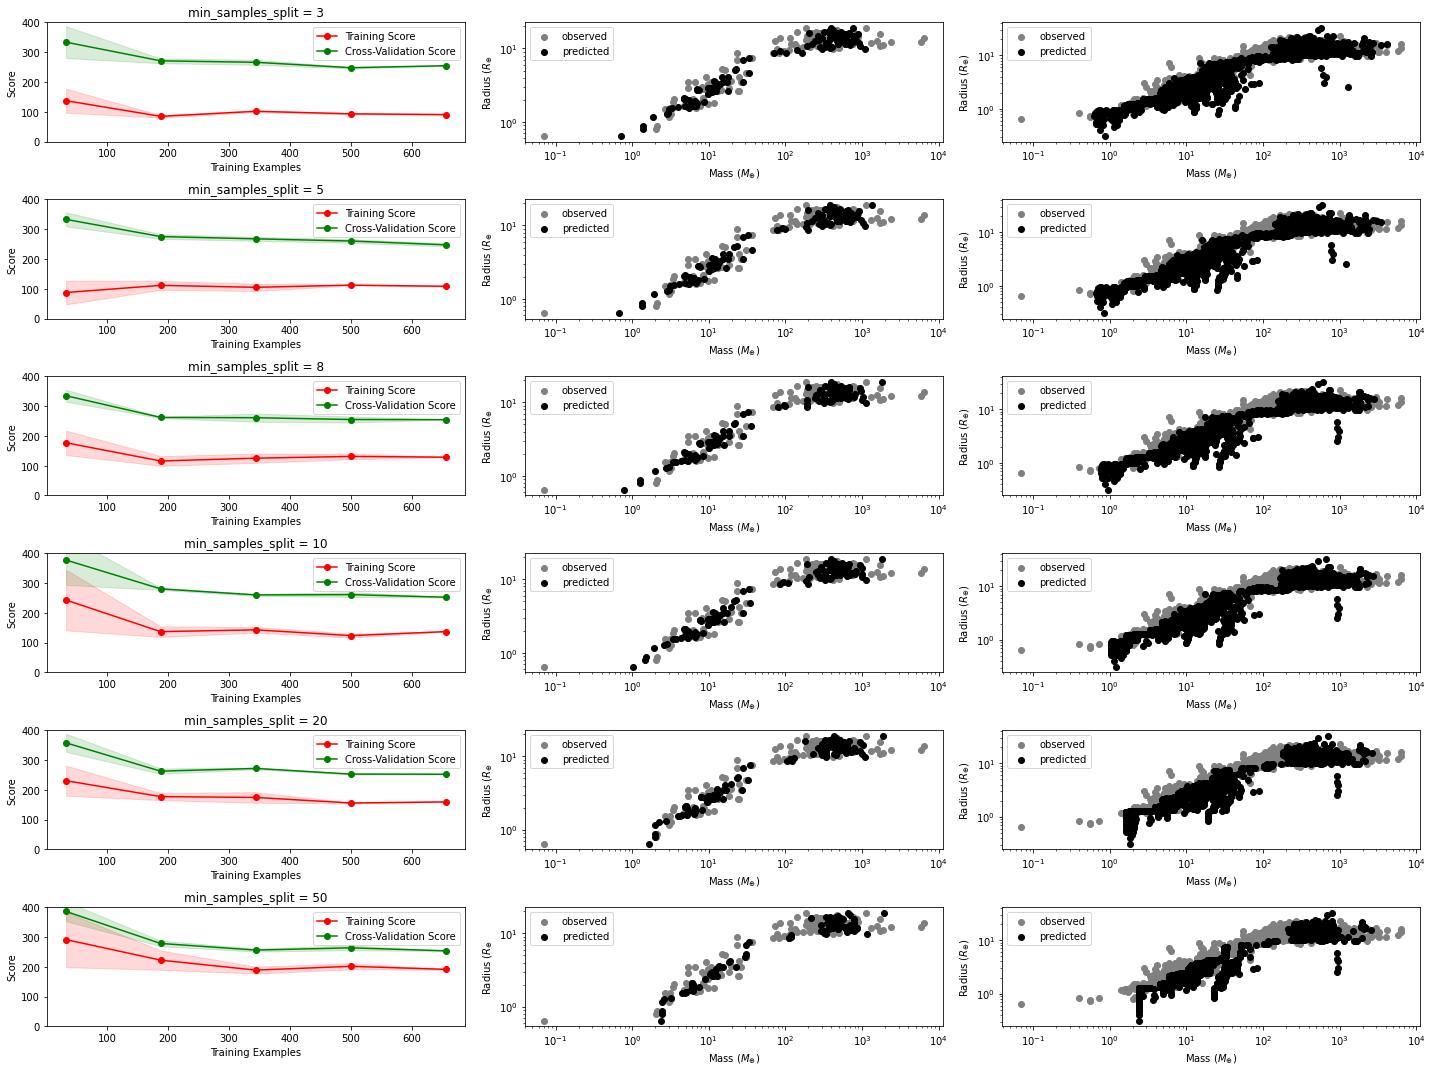

In [ ]:
LC_and_predict_plot('min_samples_split', [3, 5, 8, 10, 20, 50], X_train, y_train, X_test, y_test, scale = 'linear')

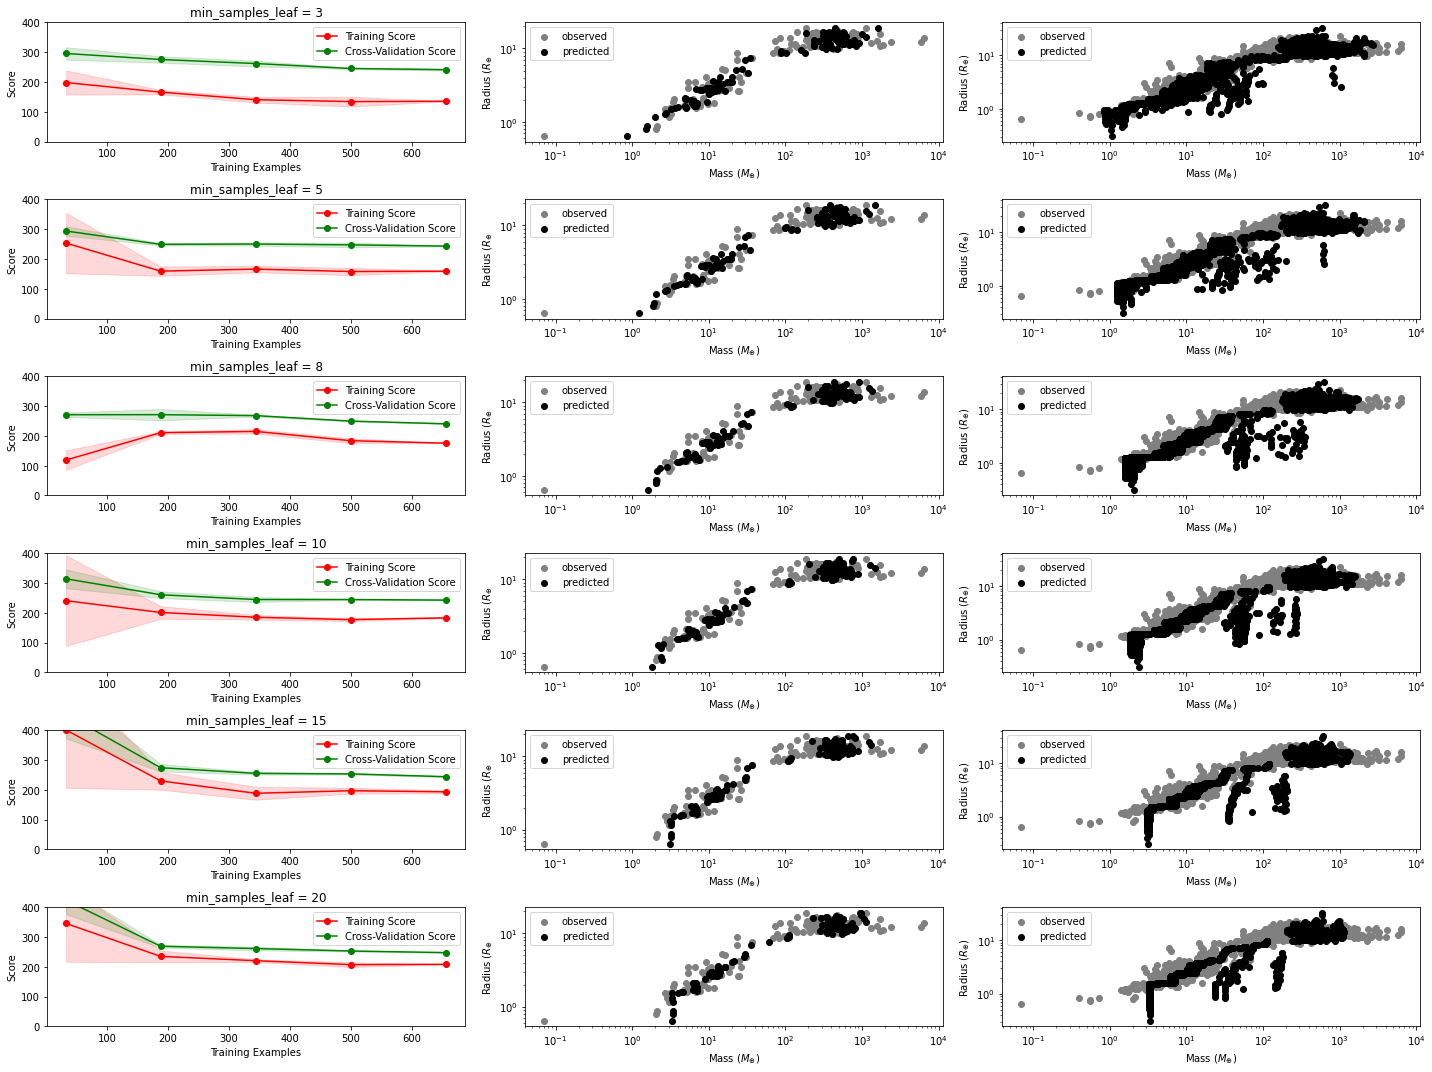

In [ ]:
LC_and_predict_plot('min_samples_leaf', [3, 5, 8, 10, 15, 20], X_train, y_train, X_test, y_test, scale = 'linear')

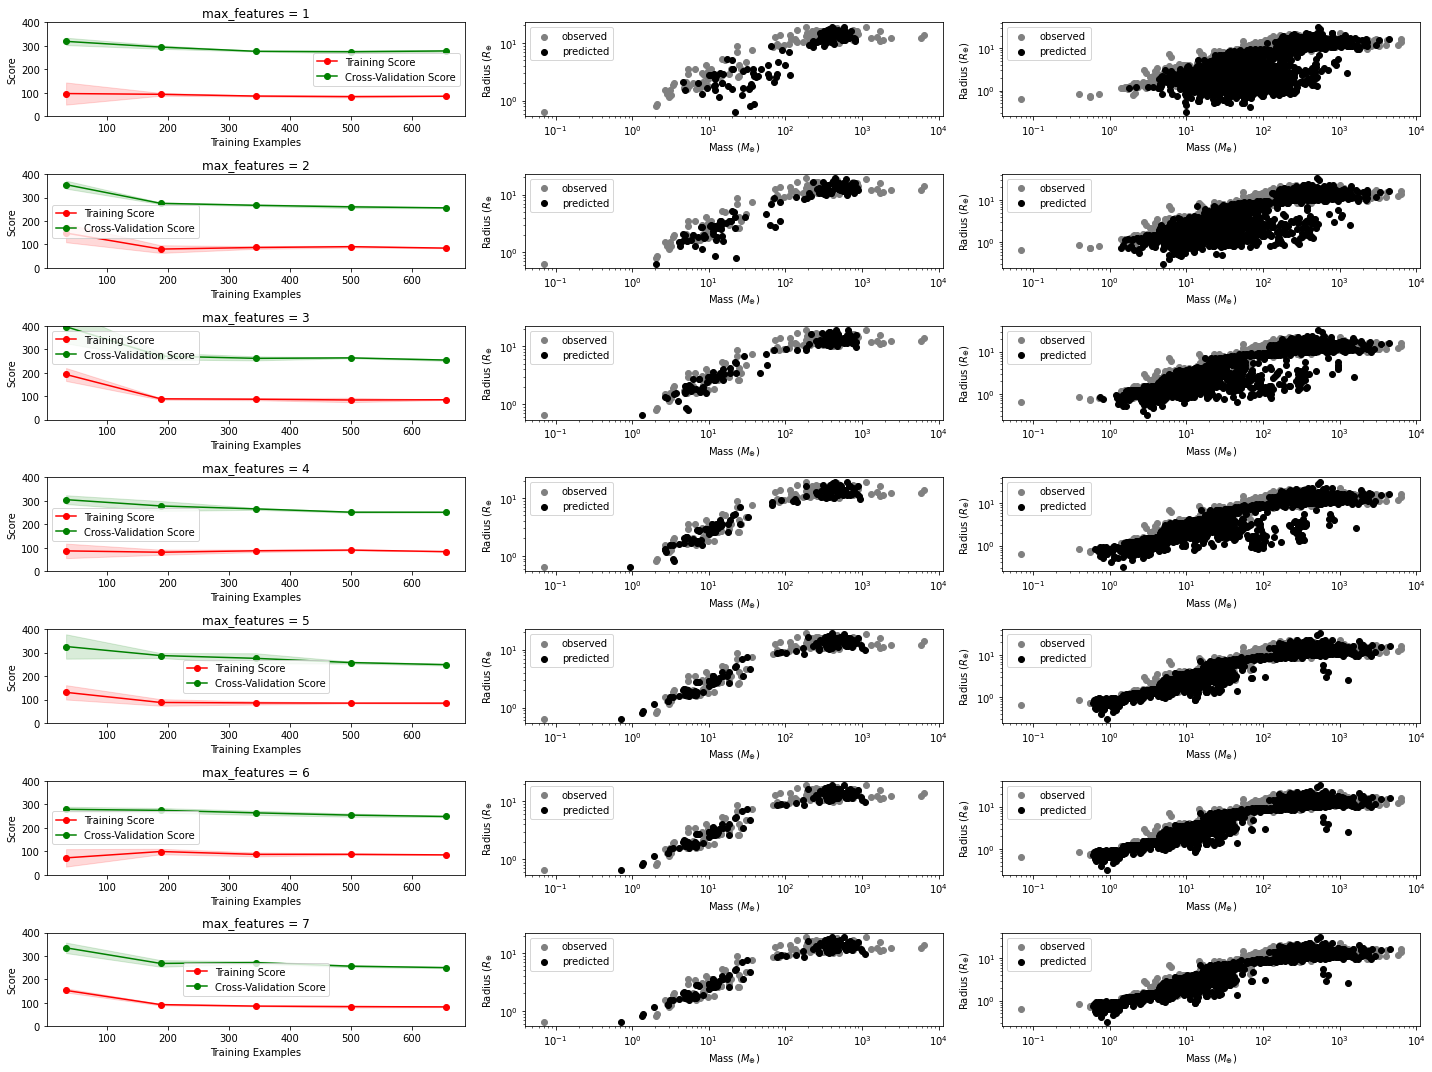

In [ ]:
LC_and_predict_plot('max_features', [1, 2, 3, 4, 5, 6, 7], X_train, y_train, X_test, y_test, scale = 'linear')

The base MAE score from the training set is 240


[I 2023-07-25 14:59:56,692] A new study created in memory with name: no-name-c5c65af1-d2d4-4d70-847e-be2f930800e2
[I 2023-07-25 14:59:57,557] Trial 0 finished with value: 220.51355762802186 and parameters: {'n_estimators': 80, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': 6}. Best is trial 0 with value: 220.51355762802186.
[I 2023-07-25 14:59:59,358] Trial 1 finished with value: 221.11159675450534 and parameters: {'n_estimators': 160, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 6}. Best is trial 0 with value: 220.51355762802186.
[I 2023-07-25 15:00:00,508] Trial 2 finished with value: 225.74390702173042 and parameters: {'n_estimators': 100, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 4}. Best is trial 0 with value: 220.51355762802186.
[I 2023-07-25 15:00:01,144] Trial 3 finished with value: 235.86717410233254 and parameters: {'n_estimators': 60, 'max_depth': 4, 'min_samples_split': 4,


The best hyperparameters for RF Regressor: {'n_estimators': 120, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 6}

MAE of the best Random Forest Regressor: Training data 173.650
MAE of the best Random Forest Regressor: Test data 248.777


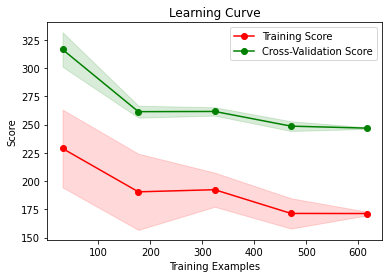

In [ ]:
best_model, final_trained_model_train_data, final_trained_model_full_data = RF_training_with_display(X,y, test_size = 0.20, n_trials = 50, display = True)

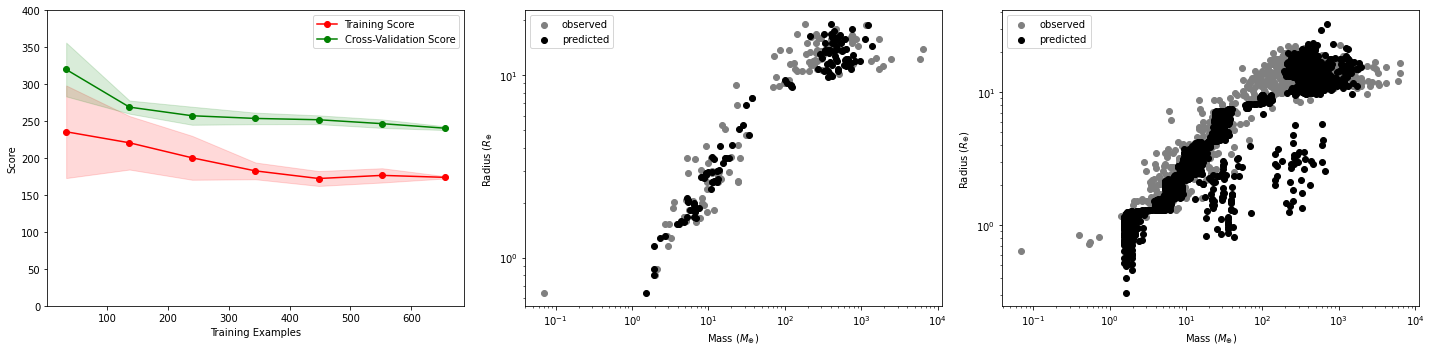

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

c = 0
model = final_trained_model_train_data #RandomForestRegressor(random_state=0, n_estimators=100, max_depth=6, min_samples_split=6, min_samples_leaf = 6, max_features=5)
results = modified_learning_curve(X_train, y_train, X_test, y_test, model, N= 7, CV=5)

ax[c].set_xlabel("Training Examples")
ax[c].set_ylabel("Score")

ax[c].plot(results['train_size'], results['mae_train_mean'], 'o-', color="r", label="Training Score")
ax[c].fill_between(results['train_size'], results['mae_train_mean'] + results['mae_train_std'],
                results['mae_train_mean'] - results['mae_train_std'],
                alpha=0.15, color='r')

ax[c].plot(results['train_size'], results['mae_test_mean'], 'o-', color="g", label="Cross-Validation Score")
ax[c].fill_between(results['train_size'], results['mae_test_mean'] + results['mae_test_std'],
                results['mae_test_mean'] - results['mae_test_std'],
                alpha=0.15, color='g')

ax[c].legend(loc="best")
ax[c].set_ylim(0,400)

model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
ax[c+1].scatter(y_test, X_test['pl_rade'], color = 'grey',  label = 'observed')
ax[c+1].scatter(y_predicted, X_test['pl_rade'], color = 'black',  label = 'predicted')
ax[c+1].legend(loc = 'best')
ax[c+1].set_xscale('log')
ax[c+1].set_yscale('log')
ax[c+1].set_xlabel('Mass ($M_{\mathrm{\oplus}}$)')
ax[c+1].set_ylabel('Radius ($R_{\mathrm{\oplus}}$')

M_pred = model.predict(R_ML_table)
ax[c+2].scatter(MR_ML_table['pl_bmasse'], MR_ML_table['pl_rade'], color = 'grey',  label = 'observed')
ax[c+2].scatter( M_pred, R_ML_table['pl_rade'], color = 'black',  label = 'predicted')
ax[c+2].legend(loc = 'best')
ax[c+2].set_xscale('log')
ax[c+2].set_yscale('log')
ax[c+2].set_xlabel('Mass ($M_{\mathrm{\oplus}}$)')
ax[c+2].set_ylabel('Radius ($R_{\mathrm{\oplus}}$)')    
plt.tight_layout()

# Training on logarithmic Mass

The masses of planets range from 0.07 to 6388 Mearth, with a mean and median values of ~340 and 160 MEarth. The skewed and bimodal distribution of the masses seems to lead to overestimation of the prediced masses and some 'strange' patterns (this might be also due to overfitting?). Better to train the model on log Masses.

In [ ]:
logMR_ML_table = MR_ML_table.copy()
logMR_ML_table['pl_bmasse_log'] = np.log10(logMR_ML_table['pl_bmasse'])

y_log = logMR_ML_table['pl_bmasse_log']
X_log = logMR_ML_table.drop(columns=['pl_bmasse', 'pl_bmasse_log'])

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, test_size=0.15)

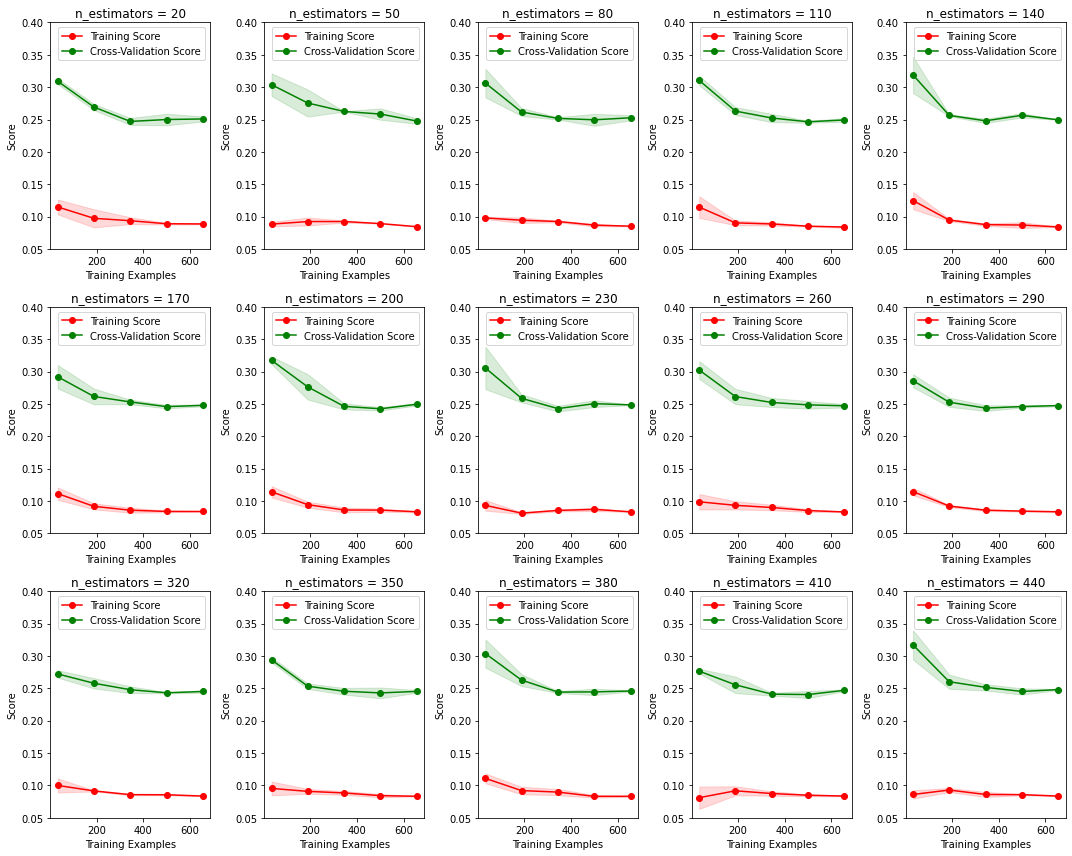

In [ ]:
LC_plot('n_estimators', 20, 470, 30, X_train_log, y_train_log, X_test_log, y_test_log, scale = 'log')

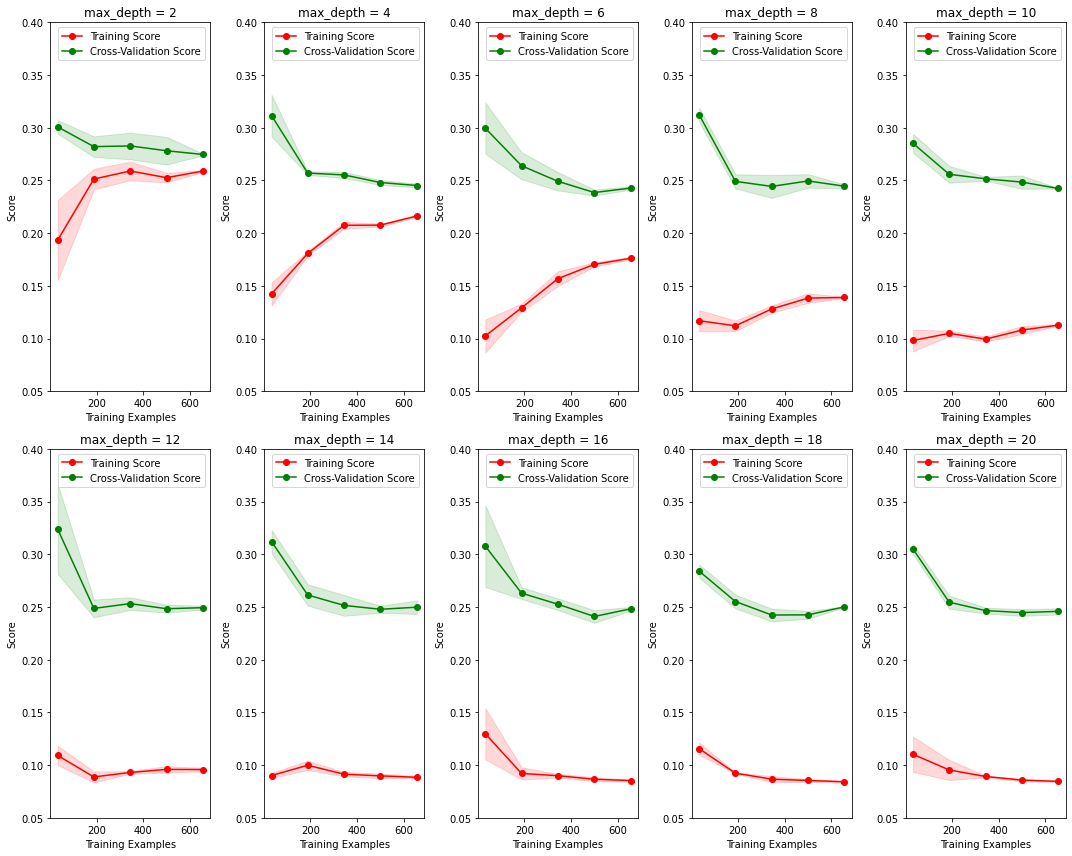

In [ ]:
LC_plot('max_depth', 2, 22, 2, X_train_log, y_train_log, X_test_log, y_test_log, scale = 'log')

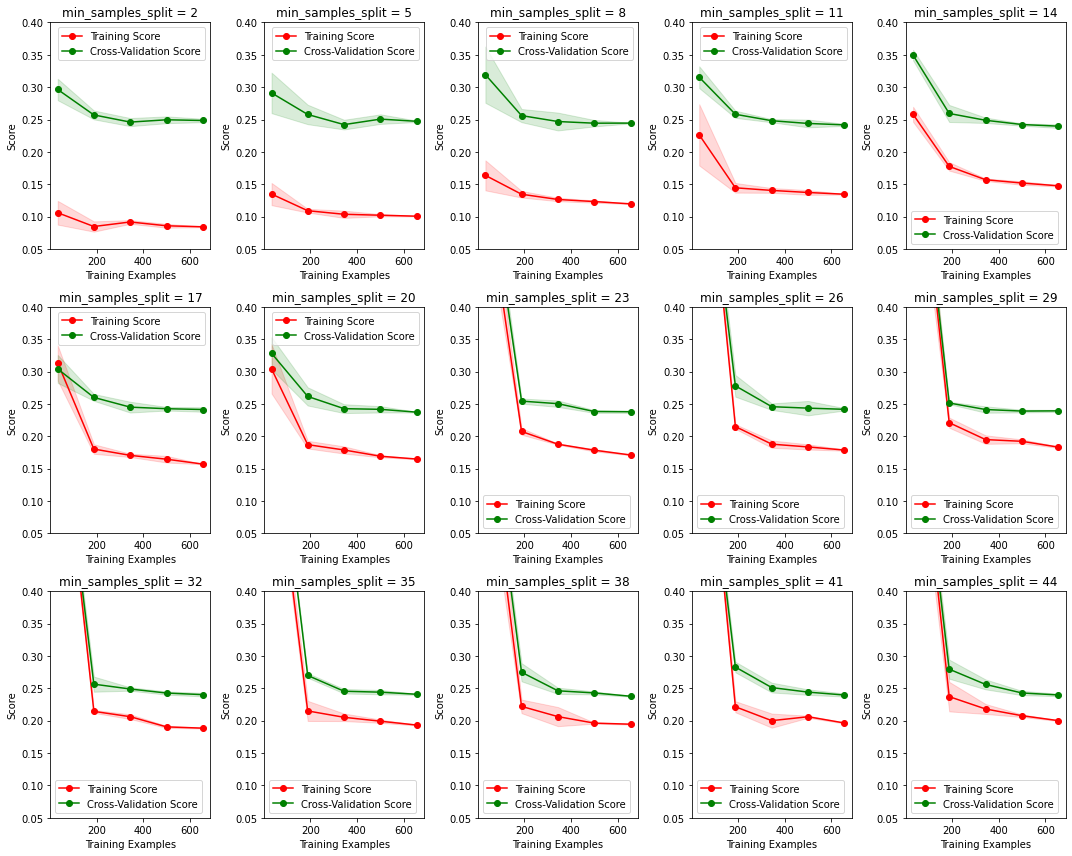

In [ ]:
LC_plot('min_samples_split', 2, 47, 3, X_train_log, y_train_log, X_test_log, y_test_log, scale = 'log')

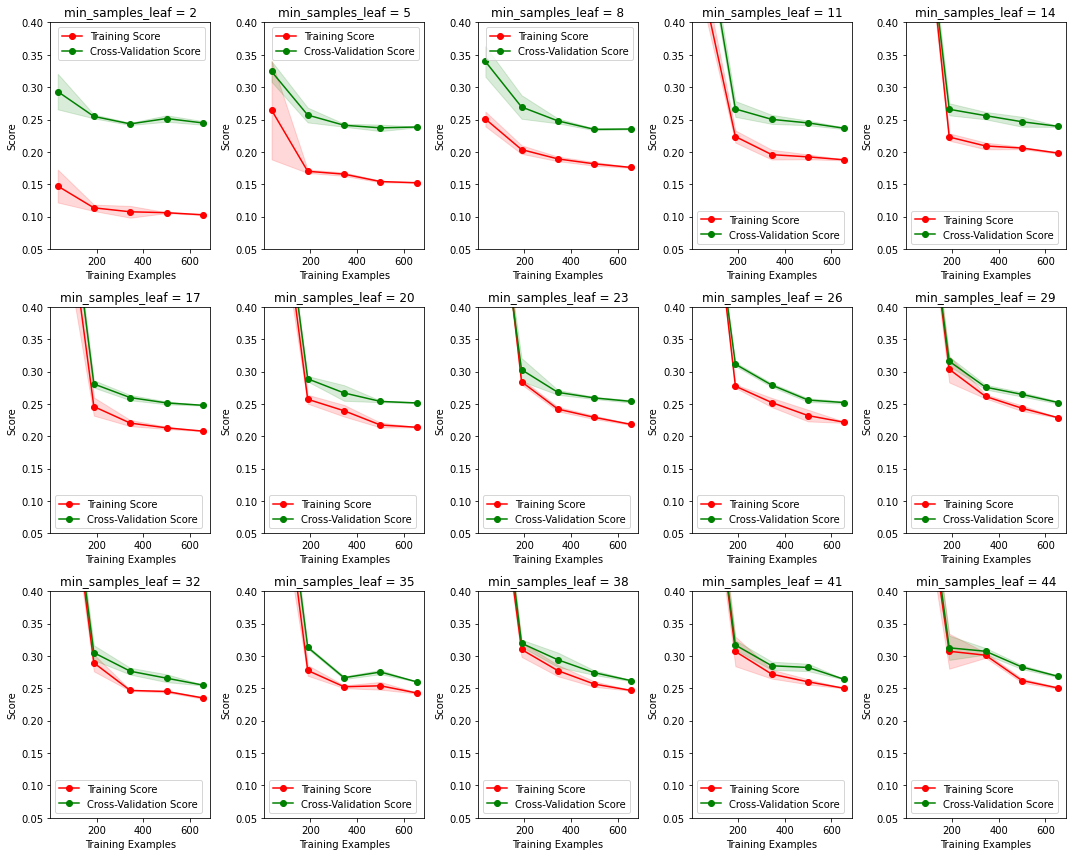

In [ ]:
LC_plot('min_samples_leaf', 2, 47, 3, X_train_log, y_train_log, X_test_log, y_test_log, scale = 'log')

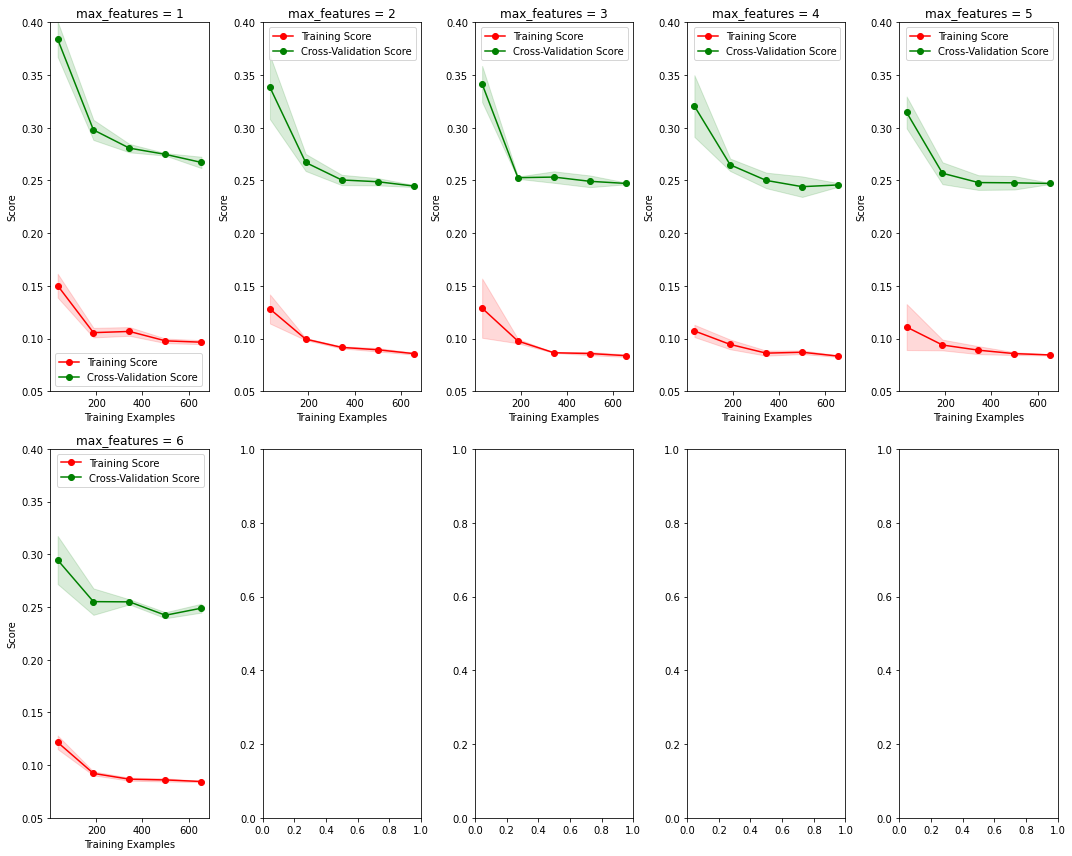

In [ ]:
LC_plot('max_features', 1, 7, 1, X_train_log, y_train_log, X_test_log, y_test_log, scale = 'log')

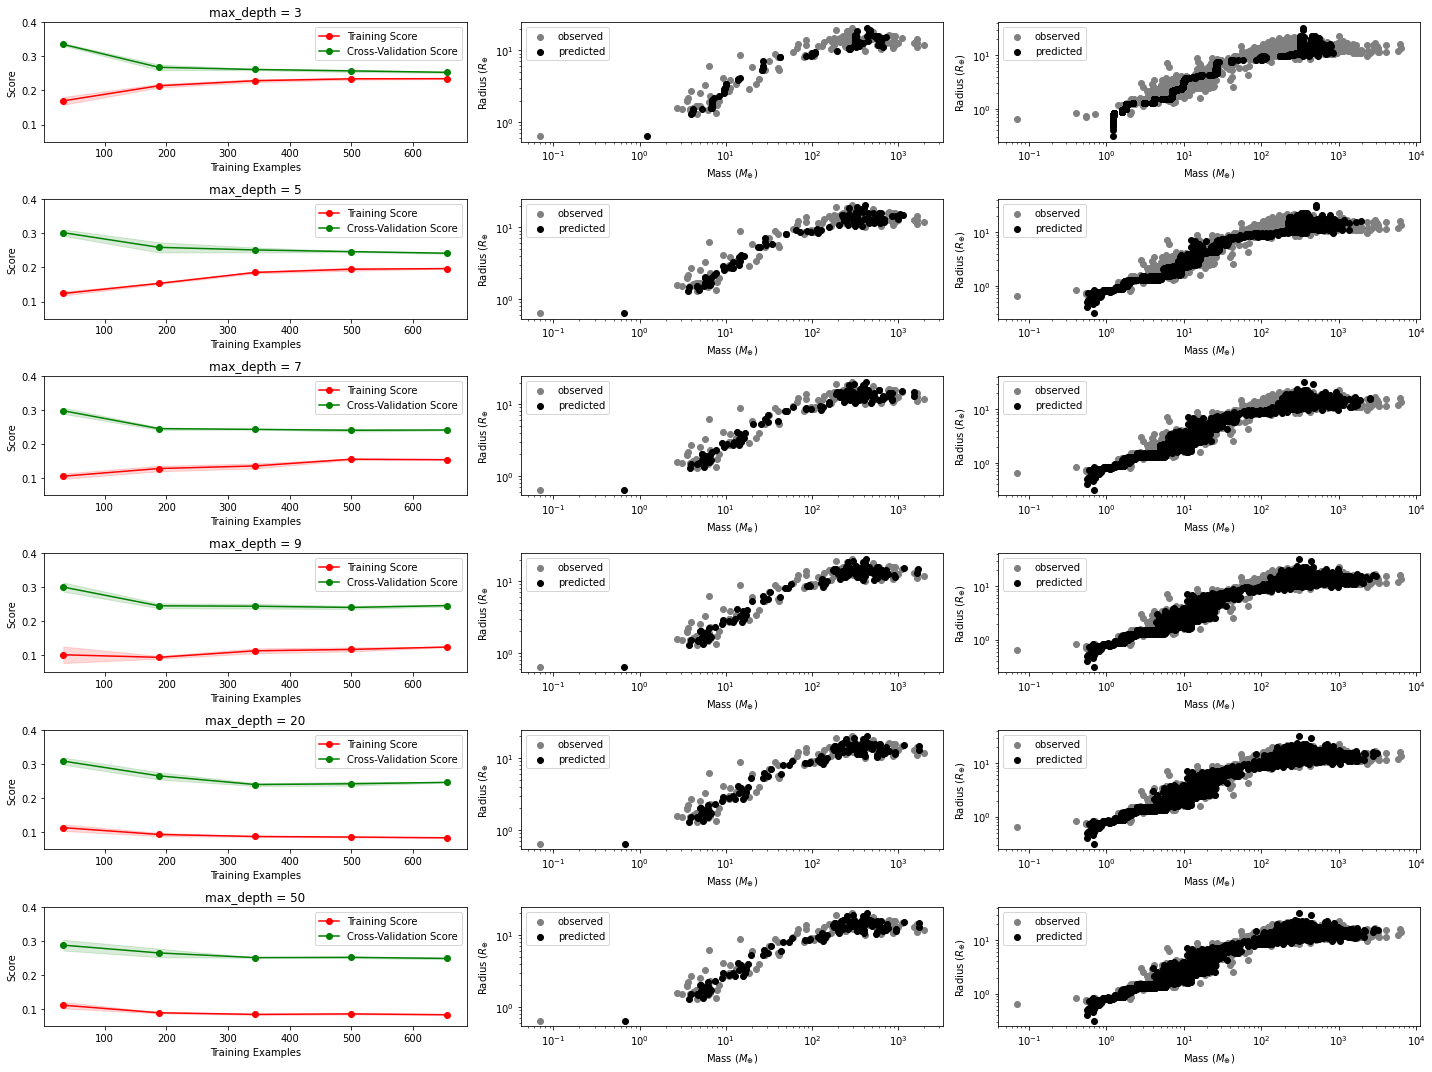

In [ ]:
LC_and_predict_plot('max_depth', [3,5,7,9,20,50], X_train_log, y_train_log, X_test_log, y_test_log, scale = 'log')

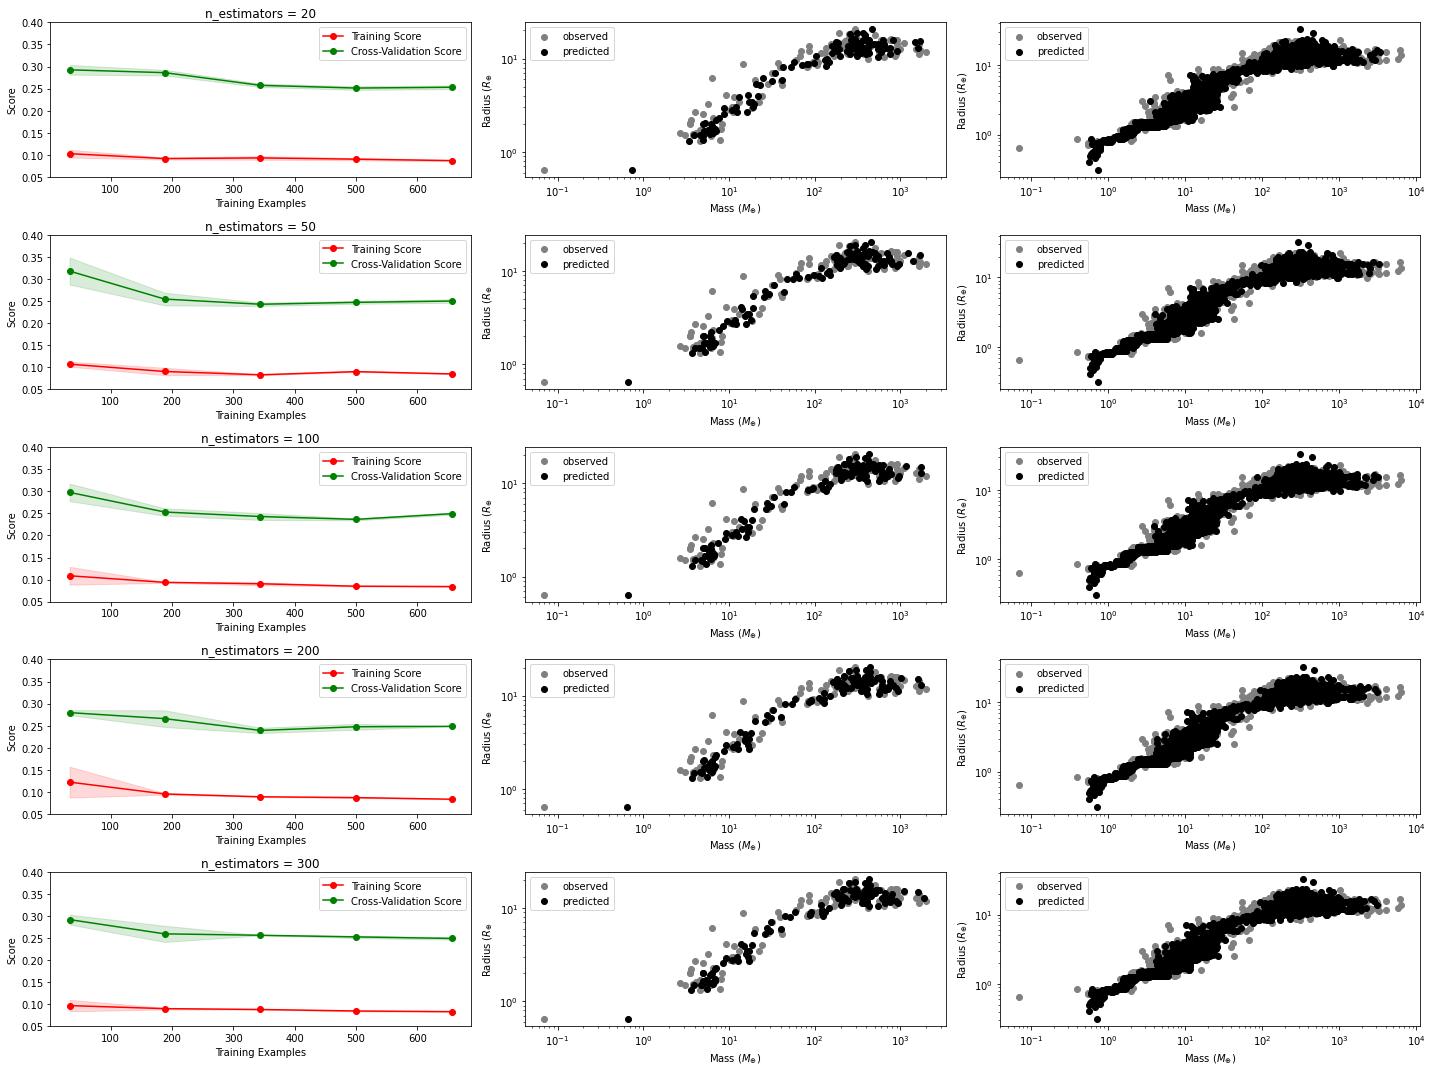

In [ ]:
LC_and_predict_plot('n_estimators', [20,50,100,200,300], X_train_log, y_train_log, X_test_log, y_test_log, scale = 'log')

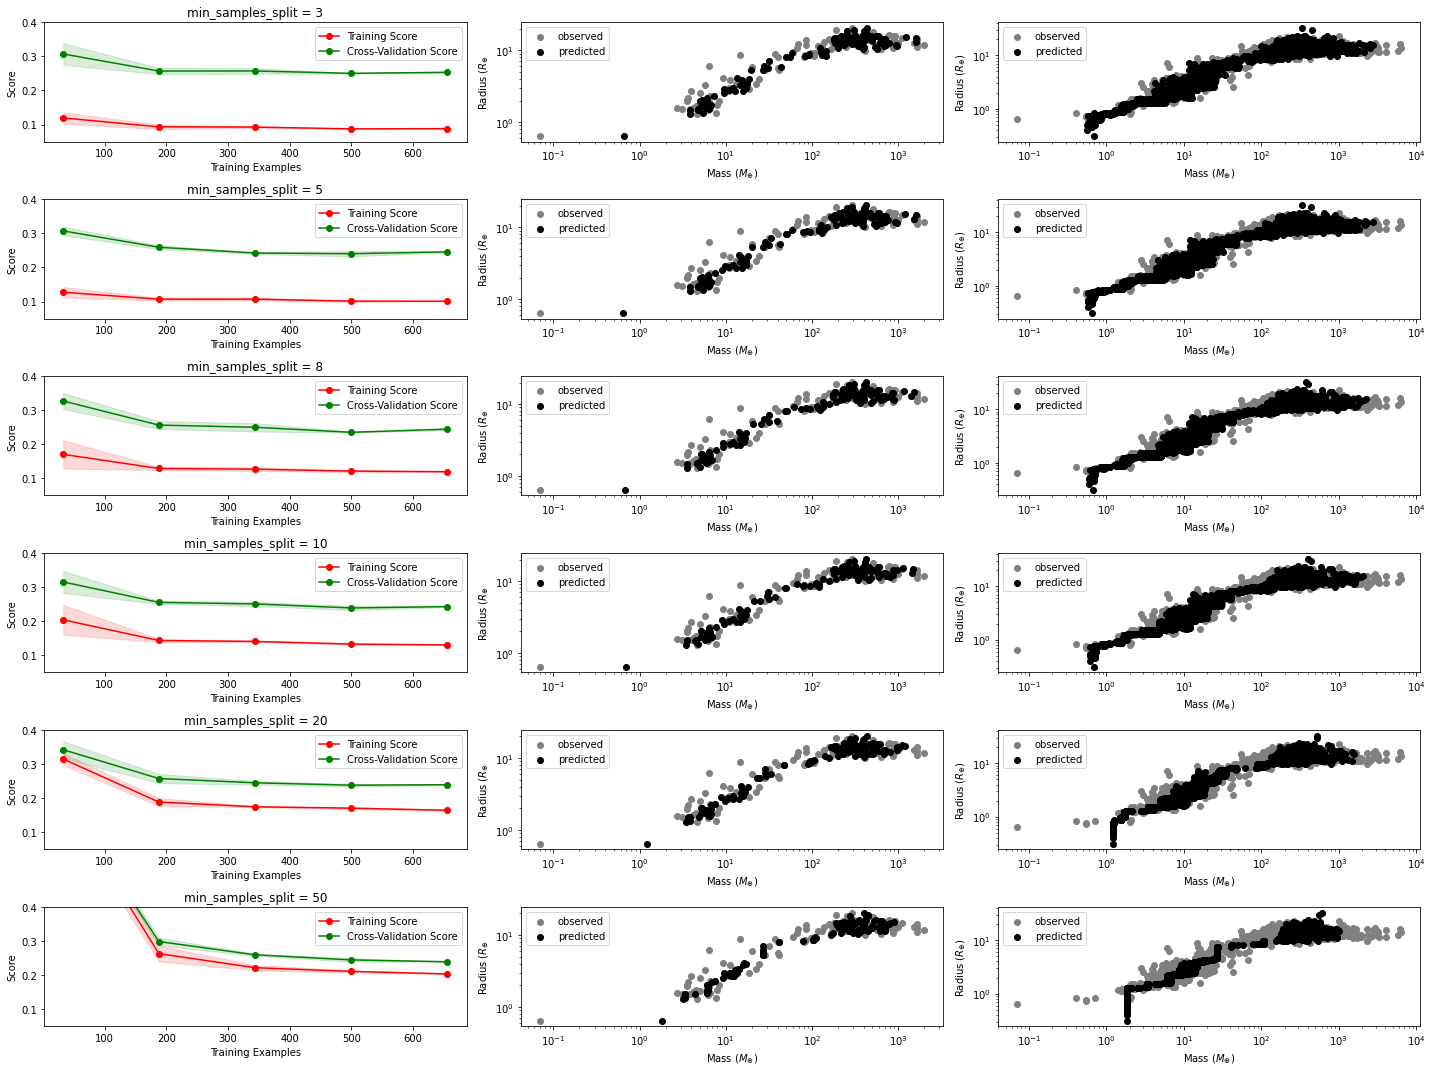

In [ ]:
LC_and_predict_plot('min_samples_split', [3, 5, 8, 10, 20], X_train_log, y_train_log, X_test_log, y_test_log, scale = 'log')

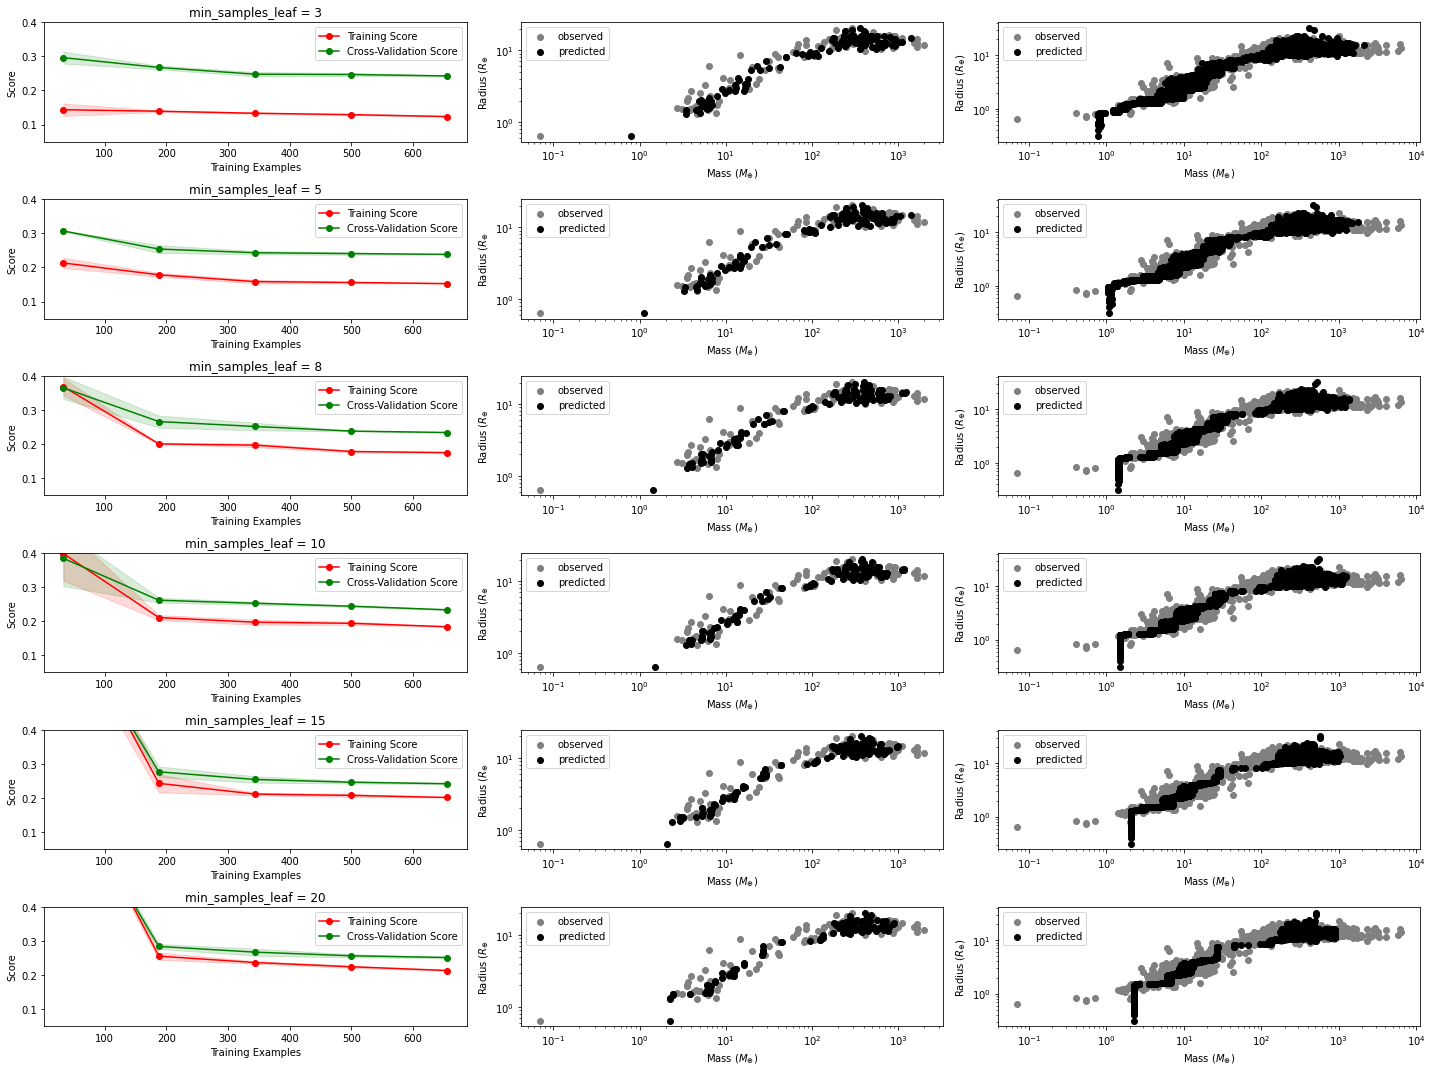

In [ ]:
LC_and_predict_plot('min_samples_leaf', [3, 5, 8, 10, 15, 20], X_train_log, y_train_log, X_test_log, y_test_log, scale = 'log')

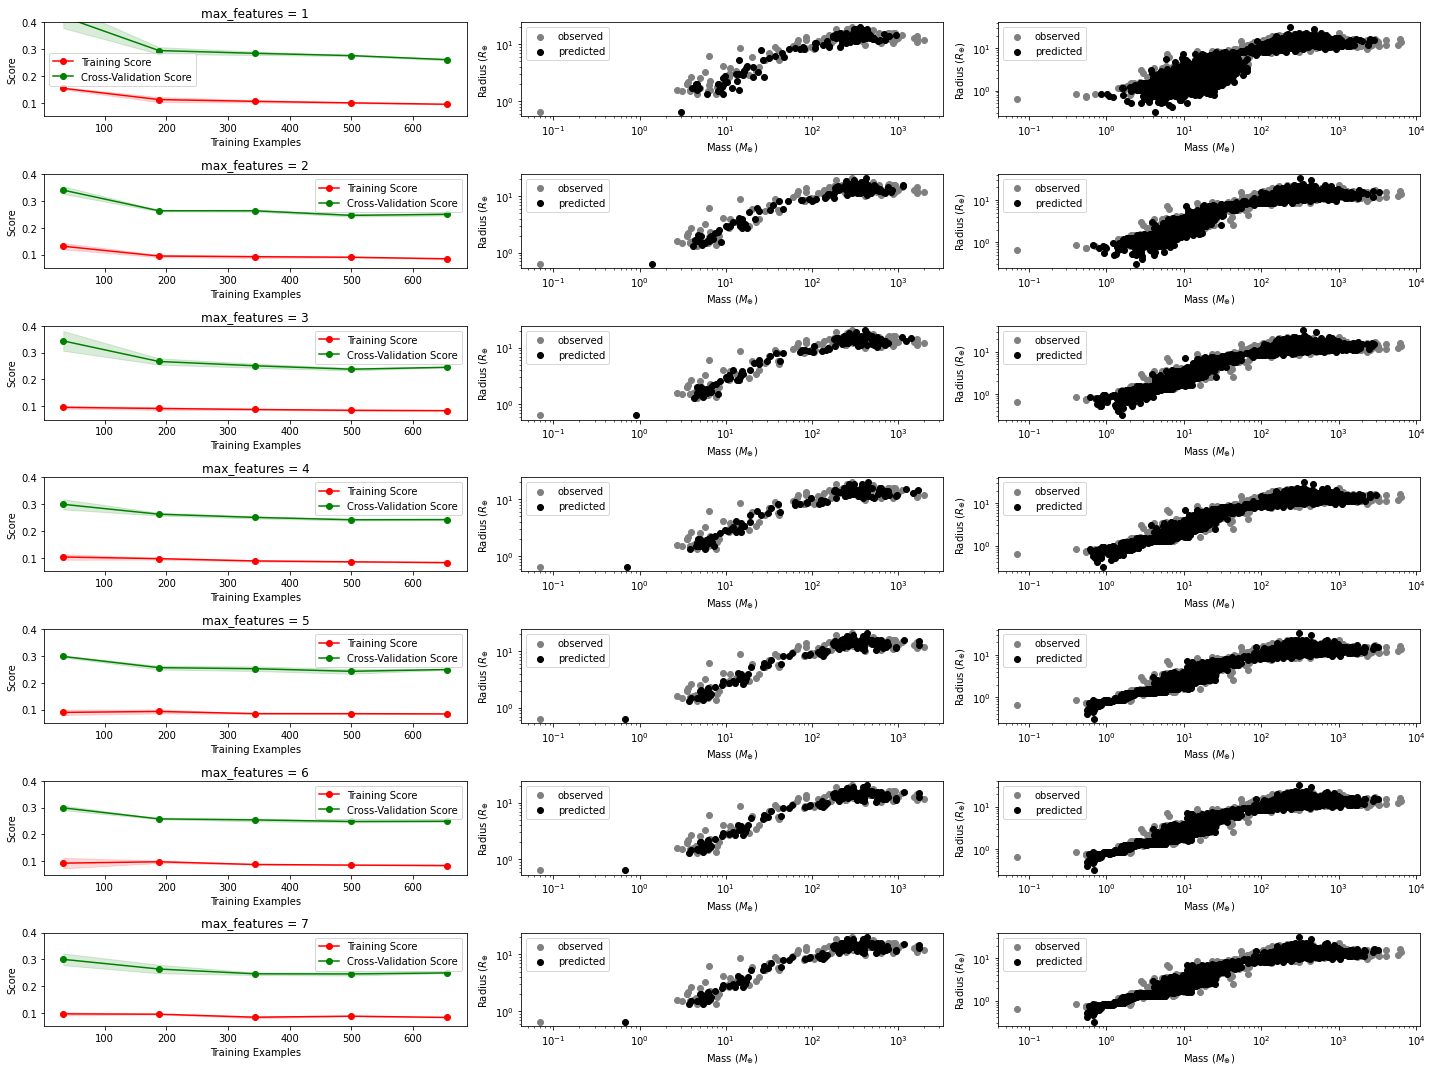

In [ ]:
LC_and_predict_plot('max_features', [1, 2, 3, 4, 5, 6, 7], X_train_log, y_train_log, X_test_log, y_test_log, scale = 'log')

[I 2023-07-25 15:35:34,548] A new study created in memory with name: no-name-27650696-ef41-452f-8b70-ce2fa10f68f8


The base MAE score from the training set is 0


[I 2023-07-25 15:35:35,782] Trial 0 finished with value: 0.23237651095918926 and parameters: {'n_estimators': 120, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': 5}. Best is trial 0 with value: 0.23237651095918926.
[I 2023-07-25 15:35:36,526] Trial 1 finished with value: 0.23098939826707202 and parameters: {'n_estimators': 60, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 6}. Best is trial 1 with value: 0.23098939826707202.
[I 2023-07-25 15:35:37,226] Trial 2 finished with value: 0.24147301491434092 and parameters: {'n_estimators': 80, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 5}. Best is trial 1 with value: 0.23098939826707202.
[I 2023-07-25 15:35:38,942] Trial 3 finished with value: 0.22848362179011522 and parameters: {'n_estimators': 180, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 3}. Best is trial 3 with value: 0.22848362179011522.
[I 2023-07-25


The best hyperparameters for RF Regressor: {'n_estimators': 160, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 4}

MAE of the best Random Forest Regressor: Training data 0.153
MAE of the best Random Forest Regressor: Test data 0.224


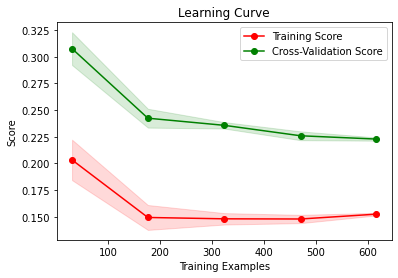

In [ ]:
best_model_log, final_trained_model_train_data_log, final_trained_model_full_data_log = RF_training_with_display(X_log,y_log, test_size = 0.20, n_trials = 50, display = True)

### Displaying predicted masses based on the model that was trained on log(M)

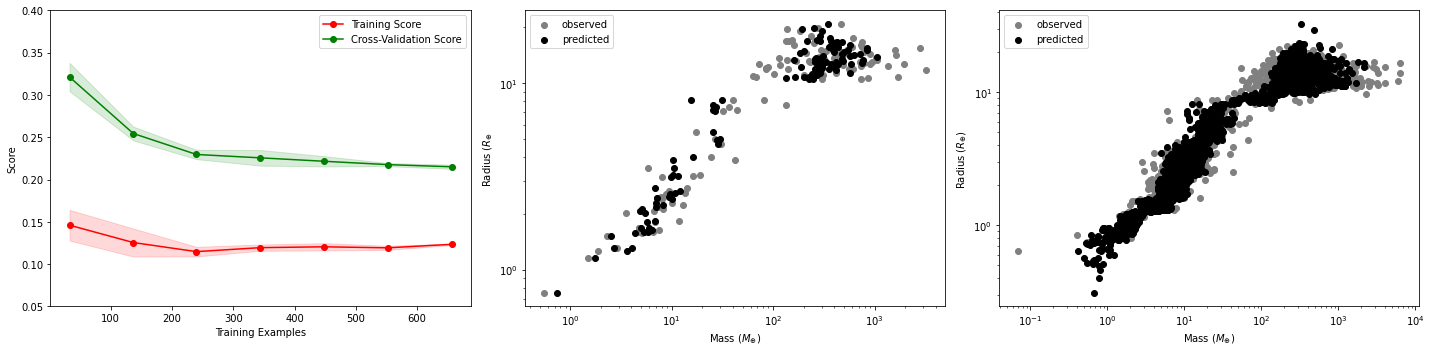

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

c = 0
model = final_trained_model_train_data_log #RandomForestRegressor(random_state=0, n_estimators=100, max_depth=6, min_samples_split=6, min_samples_leaf = 6, max_features=5)
results = modified_learning_curve(X_train_log, y_train_log, X_test_log, y_test_log, model, N= 7, CV=5)

ax[c].set_xlabel("Training Examples")
ax[c].set_ylabel("Score")

ax[c].plot(results['train_size'], results['mae_train_mean'], 'o-', color="r", label="Training Score")
ax[c].fill_between(results['train_size'], results['mae_train_mean'] + results['mae_train_std'],
                results['mae_train_mean'] - results['mae_train_std'],
                alpha=0.15, color='r')

ax[c].plot(results['train_size'], results['mae_test_mean'], 'o-', color="g", label="Cross-Validation Score")
ax[c].fill_between(results['train_size'], results['mae_test_mean'] + results['mae_test_std'],
                results['mae_test_mean'] - results['mae_test_std'],
                alpha=0.15, color='g')

ax[c].legend(loc="best")
ax[c].set_ylim(0.05,0.4)

model.fit(X_train, y_train)
y_predicted = np.power(10,model.predict(X_test))
y_test_linear = np.power(10, y_test)
ax[c+1].scatter(y_test_linear, X_test['pl_rade'], color = 'grey',  label = 'observed')
ax[c+1].scatter(y_predicted, X_test['pl_rade'], color = 'black',  label = 'predicted')
ax[c+1].legend(loc = 'best')
ax[c+1].set_xscale('log')
ax[c+1].set_yscale('log')
ax[c+1].set_xlabel('Mass ($M_{\mathrm{\oplus}}$)')
ax[c+1].set_ylabel('Radius ($R_{\mathrm{\oplus}}$)')

M_pred = np.power(10,final_trained_model_full_data_log.predict(R_ML_table))
ax[c+2].scatter(MR_ML_table['pl_bmasse'], MR_ML_table['pl_rade'], color = 'grey',  label = 'observed')
ax[c+2].scatter( M_pred, R_ML_table['pl_rade'], color = 'black',  label = 'predicted')
ax[c+2].legend(loc = 'best')
ax[c+2].set_xscale('log')
ax[c+2].set_yscale('log')
ax[c+2].set_xlabel('Mass ($M_{\mathrm{\oplus}}$)')
ax[c+2].set_ylabel('Radius ($R_{\mathrm{\oplus}}$)')    
plt.tight_layout()